# CPN generator

## Table of contents
1. [Libraries](##Libraries)
2. [Set of the Language](##Set-of-the-Language)
3. [Important functions](##important-functions)
4. [Data Cleaning](#data-cleaning)
5. [Word Embedding](##word-embedding)
6. [Model](#model)
7. [Experiments](#experiments)
8. [Search of hyperparameter *k*](#search-of-hyperparameter-k)


## [Libraries](##Libraries)

In [1]:
# Uncomment to install all the requirement
# ! pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from collections import Counter 
import random
import time

# nlp
import spacy
import gensim
from sentence_transformers import SentenceTransformer

# Clasification
import sklearn.cluster
import sklearn.tree
import sklearn.naive_bayes
from sklearn.model_selection import KFold


# Set of the random seed for the kmeans model
random.seed(0)

/home/jsmf/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## [Important Variables](##important-variables)

In [3]:
# PATHS
# This the path to run the main example, for your data change the path to your data
 
pathData = r'data/CPN120.csv'         # Path of the data to test the model
pathEmbedding = r'data/SBW-vectors-300-min5.bin'  # For example in Spanish

In [4]:
# VARIABLES
numberCluster = 500 # Number of clusters for the k-means model
numberCodes = 3 # Number of code you want as suggestion.
language = "spanish" # you can change to "english"
vertor_lenght = 768 # Length of the vector you are going to use 

## [Language Setting](#language-setting)

In [5]:
# Data import
# Relative Path of the dataset, change for your dataset
data = pd.read_csv(pathData, delimiter=",")

# Load of the LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE')
# model = SentenceTransformer('google/canine-s')


# Import of the model of the spanish billion words embeddings
# if language=="spanish":
#    model = gensim.models.KeyedVectors.load_word2vec_format( 
#    'SBW-vectors-300-min5.bin.gz', # Relative path of the vector
#    binary=True  # The model is in binary format
#    ) 
#else:
#    # Import of the model of the word2vec-google-news-300 for English dataset
#    model = gensim.models.KeyedVectors.load_word2vec_format( 
#    pathEmbedding, # Relative path of the vector
#    binary=False # The model is in binary format
#    )    


In [6]:
# The most important is the order of the 3 rows (Concept, Feature, and Code), the name itself is not important.
# Code is important for the training of the model.
data.head(5)

,Concepto,Respuesta,Codigo
0,granito,tierra,terrestre
1,granito,rugoso,texturas
2,granito,construcción,material_construccion
3,granito,desagradable al tacto,texturas
4,granito,raspa,lastimar


Installation of the Spanish pipeline. Change depending on the language you are using it.

More info in the page of spacy.

In [ ]:
# Download each one depending on your language preference

if language=="spanish":
    !python3 -m spacy download es_core_news_sm    
else:
    !python3 -m spacy download en_core_news_sm


In [8]:
# Configuration of spacy
if language=="spanish":
    nlp = spacy.load('es_core_news_sm')
else:
    nlp = spacy.load('en_core_news_sm')



## [Important functions](##important-functions)

In [9]:
def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))

# Just in case you want to use it replace for normalize
def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))


## [Data Cleaning](##data-cleaning)

In [10]:
start = time.time()
# Normalize of the feature
for i in range(len(data)):
    data['Respuesta'][i] = normalize(clean_text(data['Respuesta'][i])) # Change for the name of your dataset
end = time.time()
print("Exceution time:", end-start)

Exceution time: 62.242780685424805


## [Word Embedding](##word-embedding)

In [11]:
# Timer
start = time.time()


# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data),     # the number of data points
        vertor_lenght  # the number of components of the word embedding
    )
)

# Matrix filling 
# Change to the name of the descriptions of your dataset.
for i,description in enumerate(data.iloc[:,1]):
    vector = model.encode(description)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)


# Remove of the 'Nan' data
data_matrix = data_matrix[~pd.isnull(data_matrix[:,:vertor_lenght]).any(axis=1)]


end = time.time()
print("Exceution time:", end-start)

Exceution time: 109.77288246154785


In [12]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

train_acc = np.zeros(5)
test_acc = np.zeros(5)

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]

    
    # Model creation
    model = sklearn.naive_bayes.GaussianNB(var_smoothing=1e-09)

    model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])


    pred_train = model.predict(train[:,:vertor_lenght])
    pred_test = model.predict(test[:,:vertor_lenght])

    train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
    test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

    i+=1

In [13]:
print(train_acc.mean())
print(train_acc.std())

0.7357519518600396
0.00278653721022378


In [14]:
print(test_acc.mean())
print(test_acc.std())

0.6012434707431077
0.013285776180332484


In [15]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

rango = range(5, 61, 5)


k_acc_top_train = np.zeros((len(rango), 2))
k_acc_top_test = np.zeros((len(rango), 2))


j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_acc = np.zeros(5)
    test_acc = np.zeros(5)

    i = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]

        pca = PCA(n_components=k)

        X_train = pca.fit_transform(train[:,:vertor_lenght])
        X_test = pca.fit_transform(test[:,:vertor_lenght])

        model = sklearn.naive_bayes.GaussianNB()
        
        model.fit(X_train, train[:,vertor_lenght+2])
        
        
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        
        train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
        test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

        i+=1

    k_acc_top_train[j, 0] = train_acc.mean(axis=0)
    k_acc_top_train[j, 1] = train_acc.std(axis=0)

    k_acc_top_test[j, 0] = test_acc.mean(axis=0)
    k_acc_top_test[j, 1] = test_acc.std(axis=0)


    j+=1
    print("K =", k)
    

K = 5
K = 10
K = 15
K = 20
K = 25
K = 30
K = 35
K = 40
K = 45
K = 50
K = 55
K = 60


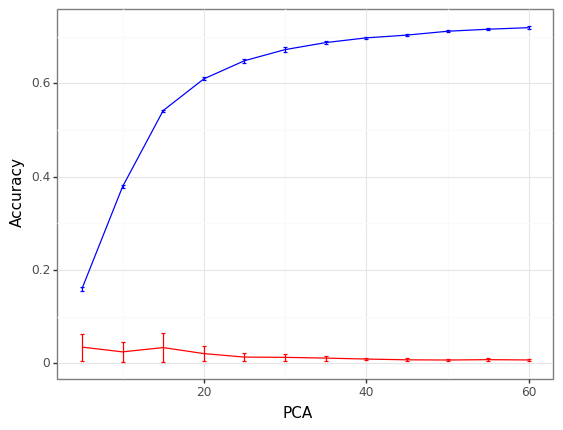

<ggplot: (8773231233028)>

In [16]:
from numpy import size
from plotnine import *

p1 = (
    ggplot()+
    aes(x=rango)+
    geom_line(aes(y=k_acc_top_test[:,0]), color="red")+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1]), color="red")+
    geom_line(aes(y=k_acc_top_train[:,0]), color='blue')+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1]), color='blue')+
    xlab("PCA")+
    ylab("Accuracy")+
    ggtitle("")+
    theme_bw()
)

p1

In [17]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

rango = range(10, 301, 10)


k_acc_top_train = np.zeros((len(rango), 2))
k_acc_top_test = np.zeros((len(rango), 2))


j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_acc = np.zeros(5)
    test_acc = np.zeros(5)

    i = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]


        model = sklearn.tree.DecisionTreeClassifier(max_depth=k)
        
        model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])
        
        
        pred_train = model.predict(train[:,:vertor_lenght])
        pred_test = model.predict(test[:,:vertor_lenght])
        
        
        train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
        test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

        i+=1

    k_acc_top_train[j, 0] = train_acc.mean(axis=0)
    k_acc_top_train[j, 1] = train_acc.std(axis=0)

    k_acc_top_test[j, 0] = test_acc.mean(axis=0)
    k_acc_top_test[j, 1] = test_acc.std(axis=0)
    
    pd.DataFrame(k_acc_top_train, columns=["mean", "std"]).to_csv("k_acc_top_train_decisionTree.csv", index=False)
    pd.DataFrame(k_acc_top_test, columns=["mean", "std"]).to_csv("k_acc_top_test_decisionTree.csv", index=False)
    

    j+=1
    print("K =", k)
    

K = 10
K = 20
K = 30
K = 40
K = 50
K = 60
K = 70
K = 80
K = 90
K = 100
K = 110
K = 120
K = 130
K = 140
K = 150
K = 160
K = 170
K = 180
K = 190
K = 200
K = 210
K = 220
K = 230
K = 240
K = 250
K = 260
K = 270
K = 280
K = 290
K = 300


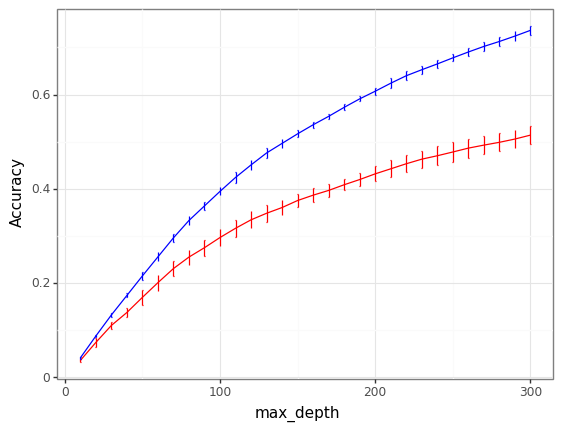

<ggplot: (8773231104412)>

In [18]:
from numpy import size
from plotnine import *

p1 = (
    ggplot()+
    aes(x=rango)+
    geom_line(aes(y=k_acc_top_test[:,0]), color="red")+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1]), color="red")+
    geom_line(aes(y=k_acc_top_train[:,0]), color='blue')+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1]), color='blue')+
    xlab("max_depth")+
    ylab("Accuracy")+
    ggtitle("")+
    theme_bw()
)

p1

In [19]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

train_acc = np.zeros(5)
test_acc = np.zeros(5)

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]

    
    # Model creation
    model = sklearn.svm.LinearSVC(random_state=0, tol=1e-5, multi_class="crammer_singer")
    

    model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])


    pred_train = model.predict(train[:,:vertor_lenght])
    pred_test = model.predict(test[:,:vertor_lenght])

    train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
    test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

    i+=1


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


In [20]:
print(train_acc.mean())
print(train_acc.std())

0.8241746127705711
0.0014877183524773518


In [21]:
print(test_acc.mean())
print(test_acc.std())

0.6779441803142159
0.00802633536079044


In [22]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

rango = np.array([10**(i-3) for i in range(6)])

k_acc_top_train = np.zeros((len(rango), 2))
k_acc_top_test = np.zeros((len(rango), 2))


j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_acc = np.zeros(5)
    test_acc = np.zeros(5)

    i = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]


        model = sklearn.svm.LinearSVC(random_state=0, tol=1e-5, C=k, multi_class="crammer_singer")
        
        model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])
        
        
        pred_train = model.predict(train[:,:vertor_lenght])
        pred_test = model.predict(test[:,:vertor_lenght])
        
        
        train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
        test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

        i+=1

    k_acc_top_train[j, 0] = train_acc.mean(axis=0)
    k_acc_top_train[j, 1] = train_acc.std(axis=0)

    k_acc_top_test[j, 0] = test_acc.mean(axis=0)
    k_acc_top_test[j, 1] = test_acc.std(axis=0)
    
    pd.DataFrame(k_acc_top_train, columns=["mean", "std"]).to_csv("k_acc_top_train_svm.csv", index=False)
    pd.DataFrame(k_acc_top_test, columns=["mean", "std"]).to_csv("k_acc_top_test_svm.csv", index=False)
    

    j+=1
    print("K =", k)
    

/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 0.001


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 0.01


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 0.1


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 1.0


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 10.0


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


K = 100.0


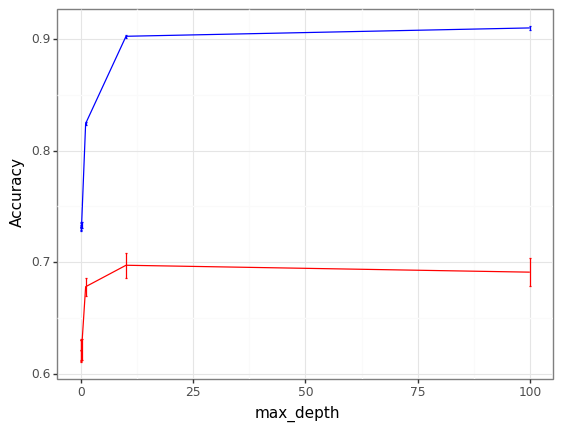

<ggplot: (8773231115394)>

In [23]:
from numpy import size
from plotnine import *

p1 = (
    ggplot()+
    aes(x=rango)+
    geom_line(aes(y=k_acc_top_test[:,0]), color="red")+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1]), color="red")+
    geom_line(aes(y=k_acc_top_train[:,0]), color='blue')+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1]), color='blue')+
    xlab("max_depth")+
    ylab("Accuracy")+
    ggtitle("")+
    theme_bw()
)

p1

In [24]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

train_acc = np.zeros(5)
test_acc = np.zeros(5)

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]

    
    # Model creation
    model = sklearn.linear_model.LogisticRegression(random_state=0, multi_class="multinomial")
    

    model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])


    pred_train = model.predict(train[:,:vertor_lenght])
    pred_test = model.predict(test[:,:vertor_lenght])

    train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
    test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

    i+=1


In [25]:
print(train_acc.mean())
print(train_acc.std())

0.5854883796346148
0.0036850082623672608


In [26]:
print(test_acc.mean())
print(test_acc.std())

0.539825903556366
0.007543275992995028


In [27]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

rango = np.array([10**(i-3) for i in range(6)])

k_acc_top_train = np.zeros((len(rango), 2))
k_acc_top_test = np.zeros((len(rango), 2))


j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_acc = np.zeros(5)
    test_acc = np.zeros(5)

    i = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]

        model = sklearn.linear_model.LogisticRegression(random_state=0, C=k, multi_class="multinomial")
        
        model.fit(train[:,:vertor_lenght], train[:,vertor_lenght+2])
        
        
        pred_train = model.predict(train[:,:vertor_lenght])
        pred_test = model.predict(test[:,:vertor_lenght])
        
        
        train_acc[i] = sum(pred_train==train[:,vertor_lenght+2])/len(pred_train)
        test_acc[i] = sum(pred_test==test[:,vertor_lenght+2])/len(pred_test)

        i+=1

    k_acc_top_train[j, 0] = train_acc.mean(axis=0)
    k_acc_top_train[j, 1] = train_acc.std(axis=0)

    k_acc_top_test[j, 0] = test_acc.mean(axis=0)
    k_acc_top_test[j, 1] = test_acc.std(axis=0)
    
    pd.DataFrame(k_acc_top_train, columns=["mean", "std"]).to_csv("k_acc_top_train_logreg.csv", index=False)
    pd.DataFrame(k_acc_top_test, columns=["mean", "std"]).to_csv("k_acc_top_test_logreg.csv", index=False)
    

    j+=1
    print("K =", k)
    

/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-

K = 0.001
K = 0.01
K = 0.1
K = 1.0


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-

K = 10.0


/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/jsmf/.local/lib/python3.10/site-

K = 100.0


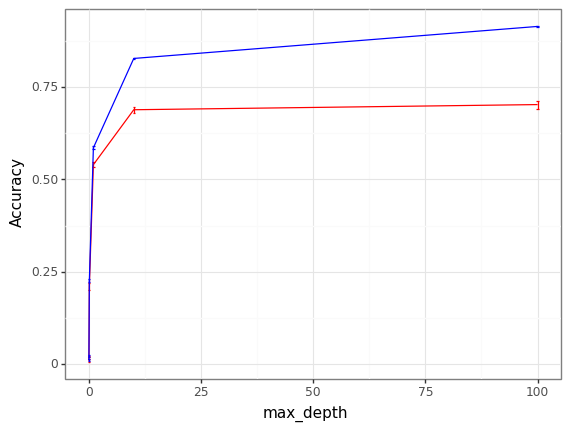

<ggplot: (8773231156110)>

In [28]:
from numpy import size
from plotnine import *

p1 = (
    ggplot()+
    aes(x=rango)+
    geom_line(aes(y=k_acc_top_test[:,0]), color="red")+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1]), color="red")+
    geom_line(aes(y=k_acc_top_train[:,0]), color='blue')+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1]), color='blue')+
    xlab("max_depth")+
    ylab("Accuracy")+
    ggtitle("")+
    theme_bw()
)

p1